**Exploratory Engineering of Systematic Macro Features (2000–2025)**
- Event Response Features : The goal is to capture systematic market responses to macro catalysts and convert them into reusable features for signal research.

- Unlike traditional event studies, which are typically one-off analyses that examine average responses around specific events, this approach avoids purely descriptive results that are difficult to reuse or integrate into a larger research framework. Instead, the focus is on converting macroeconomic events into time-indexed features that exist across the full sample, not only on event dates. These features can be directly incorporated into predictive models, regime analysis, and cross-asset signal research. In simple terms, the objective is not to study events in isolation, but to understand how markets encode macroeconomic information over time.

- Traditional macroeconomic analysis often emphasizes point-in-time event reactions or static indicator levels. The true value of macroeconomic data lies in its stochastic innovations (shocks) and in its ability to act as a regime filter for asset returns. By focusing on changes, surprises, and state-dependent responses rather than levels alone, this framework captures how macro information propagates through financial markets and conditions the behavior of equities and commodities across different economic environments.

**Overview of Plan**
1. **Information Ingestion**: Centralizing disparate frequency data (monthly, quarterly) into a daily-aligned temporal framework.
2. **The Macro State Layer**: Mapping slow-moving growth and inflation dynamics into a four-quadrant regime model.
3. **Standardized Shocks**: Normalizing macro innovations by realized volatility to capture "surprise" magnitude.
4. **Cross-Asset Sensitivity**: Projecting macro states onto equity and commodity risk premia.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Basic Plotting Configuration - I will be adding more to this based on need below for some visuals use-case.
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.style.use('ggplot')
sns.set_theme(style="whitegrid", palette="viridis")
warnings.filterwarnings("ignore")

print("Environment initialized: High-fidelity research mode active.")
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.feature_eng import FeatureEngineer

Environment initialized: High-fidelity research mode active.


**Data Ingestion & Alignment**

Integrating the preprocessed macro indicators with high-frequency asset prices, ensuring all information is correctly lagged to avoid look-ahead bias.

In [2]:
def load_macro_quant_data(base_dir=".."):
    """
    Loads macro and asset datasets, ensuring they are aligned on a daily business day index.
    """
    # Load Macro
    macro_path = os.path.join(base_dir, "data/processed/macro_processed.csv")
    if not os.path.exists(macro_path):
        macro_path = "data/processed/macro_processed.csv"
    macro = pd.read_csv(macro_path, index_col=0, parse_dates=True)
    
    # Load Core Assets (SPY as Proxy for Equities, GLD for Commodities)
    # We iterate through the raw directories to build a multi-asset panel
    assets = {}
    for folder in ["equities", "commodities", "sectors"]:
        dir_path = os.path.join(base_dir, "data/raw", folder)
        if not os.path.exists(dir_path):
            dir_path = os.path.join("data/raw", folder)
            
        for f in [x for x in os.listdir(dir_path) if x.endswith(".csv")]:
            ticker = f.replace(".csv", "")
            df = pd.read_csv(os.path.join(dir_path, f), index_col=0, parse_dates=True)
            assets[ticker] = df.iloc[:, 0] # Assume first column is the target price
            
    prices = pd.DataFrame(assets).sort_index()
    
    # Align
    common_idx = macro.index.intersection(prices.index)
    return macro.loc[common_idx], prices.loc[common_idx]

macro_raw, prices_raw = load_macro_quant_data()
print(f"Ingested {macro_raw.shape[1]} macro series and {prices_raw.shape[1]} asset tickers.")
print(f"Time-span: {macro_raw.index.min().date()} to {macro_raw.index.max().date()}")

print(macro_raw.head())
print(prices_raw.head())


Ingested 9 macro series and 13 asset tickers.
Time-span: 2000-01-03 to 2025-12-30
            DGS10   INDPRO  UNRATE  CPIAUCSL  DCOILWTICO  FEDFUNDS  VIXCLS  \
2000-01-03   6.58  91.8239     4.1     170.0       25.56      5.73   24.21   
2000-01-04   6.49  91.8239     4.1     170.0       25.56      5.73   27.01   
2000-01-05   6.62  91.8239     4.1     170.0       24.65      5.73   26.41   
2000-01-06   6.57  91.8239     4.1     170.0       24.79      5.73   25.73   
2000-01-07   6.52  91.8239     4.1     170.0       24.79      5.73   21.72   

            UMCSENT        GDP  
2000-01-03    111.3  10660.465  
2000-01-04    111.3  10660.465  
2000-01-05    111.3  10660.465  
2000-01-06    111.3  10660.465  
2000-01-07    111.3  10660.465  
                  QQQ  IWM        DIA        SPY  GLD  USO  DBC  SLV  \
2000-01-03  80.028175  NaN  64.949814  91.617035  NaN  NaN  NaN  NaN   
2000-01-04  74.538124  NaN  62.812862  88.034279  NaN  NaN  NaN  NaN   
2000-01-05  72.637733  NaN  63.6264

**The Macro State Layer (State Filter)**

**Economic Intuition**
- Market participants do not price information in a vacuum. The propagation of a shock is conditional on the **Macro Regime**.  Applying a Z-score transformation to define "Extreme" vs "Normal" states and construct a **Growth-Inflation Quadrant**.

**Regime Definition:**
- **Goldilocks**: High Growth, Low Inflation
- **Stagflation**: Low Growth, High Inflation
- **Reflation**: High Growth, High Inflation
- **Deflationary Recession**: Low Growth, Low Inflation

**Note:** I have some material references I will add to this regime definitions|

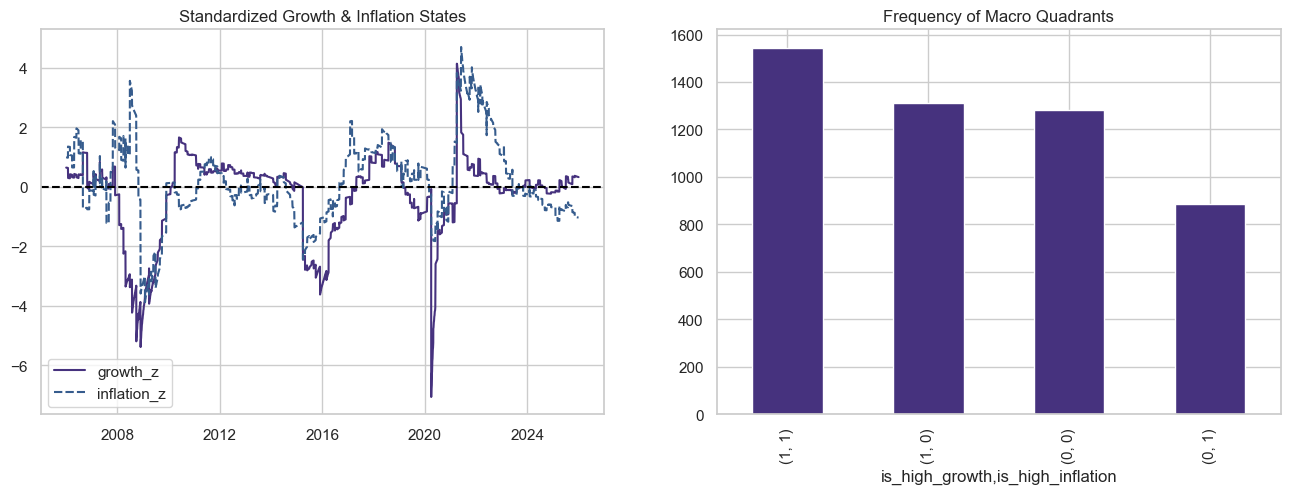

In [3]:
def engineer_state_features(df):
    """
    Transforms raw levels into standardized state indicators.
    """
    states = pd.DataFrame(index=df.index)
    
    # Growth Proxy (Industrial Production YoY - INDPRO)
    states['growth_z'] = (df['INDPRO'].pct_change(252) - df['INDPRO'].pct_change(252).rolling(1260).mean()) / df['INDPRO'].pct_change(252).rolling(1260).std()
    
    # Inflation Proxy (CPI YoY - CPIAUCSL)
    states['inflation_z'] = (df['CPIAUCSL'].pct_change(252) - df['CPIAUCSL'].pct_change(252).rolling(1260).mean()) / df['CPIAUCSL'].pct_change(252).rolling(1260).std()
    
    # Monetary Tightness (Fed Funds vs 10Y Yield)
    states['yield_curve'] = df['DGS10'] - df['FEDFUNDS']
    
    # Sentiment (Michigan Consumer Sentiment standardized)
    states['sentiment_z'] = (df['UMCSENT'] - df['UMCSENT'].rolling(1260).mean()) / df['UMCSENT'].rolling(1260).std()
    
    # Quadrants Definition (Binary Filters)
    states['is_high_growth'] = (states['growth_z'] > 0).astype(int)
    states['is_high_inflation'] = (states['inflation_z'] > 0).astype(int)
    
    return states.dropna()

macro_states = engineer_state_features(macro_raw)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(data=macro_states[['growth_z', 'inflation_z']], ax=ax[0])
ax[0].set_title("Standardized Growth & Inflation States")
ax[0].axhline(0, color='black', linestyle='--')

macro_states[['is_high_growth', 'is_high_inflation']].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title("Frequency of Macro Quadrants")
plt.show()

**Shocks & Information Catalysts**

**Statistical Rationale**
- To build predictive signals, we will be converting non-stationary macro levels into **stationary innovations**. We will define a "Macro Shock" as the daily innovation normalized by its rolling standard deviation. This allows us to compare the relative impact of a VIX spike vs a Fed Funds move on the same scale.

In [4]:
def engineer_shock_features(df):
    """
    Constructs volatility-normalized shocks for market-moving variables.
    """
    shocks = pd.DataFrame(index=df.index)
    
    # Interest Rate Shocks
    shocks['rate_shock'] = df['DGS10'].diff() / df['DGS10'].diff().rolling(60).std()
    
    # Energy Shocks (Log returns normalized)
    shocks['energy_shock'] = np.log(df['DCOILWTICO']).diff() / np.log(df['DCOILWTICO']).diff().rolling(60).std()
    
    # Volatility Shocks (VIX levels change normalized)
    shocks['vol_shock'] = df['VIXCLS'].diff() / df['VIXCLS'].diff().rolling(60).std()
    
    return shocks.dropna()

macro_shocks = engineer_shock_features(macro_raw)

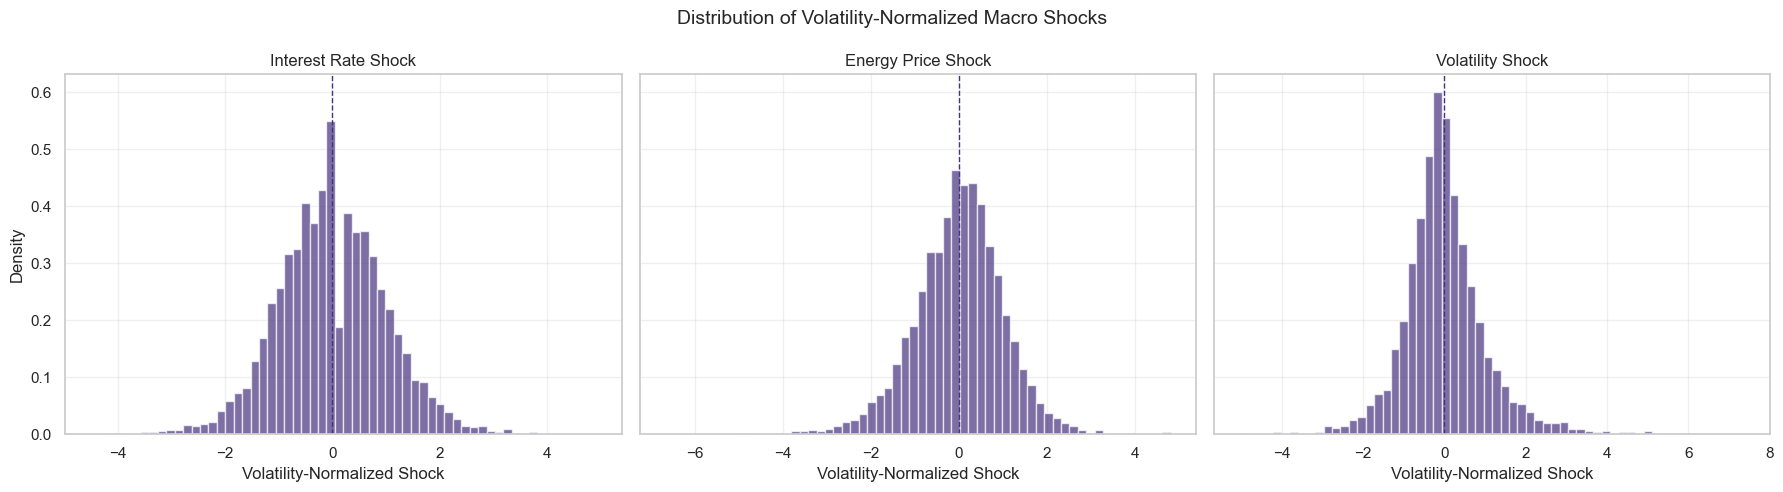

In [5]:
# Better visualization for shock features
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

shock_cols = {
    "rate_shock": "Interest Rate Shock",
    "energy_shock": "Energy Price Shock",
    "vol_shock": "Volatility Shock"
}

for ax, (col, title) in zip(axes, shock_cols.items()):
    ax.hist(
        macro_shocks[col],
        bins=60,
        density=True,
        alpha=0.7
    )
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Volatility-Normalized Shock")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Density")

plt.suptitle("Distribution of Volatility-Normalized Macro Shocks", fontsize=14)
plt.tight_layout()
plt.show()

**Macro-Financial Sensitivity (Dynamic Linkages)**

**Question?**
- How does the linkage between equities (SPY) and commodities (GLD) shift across macro states? We use rolling correlations weighted by macro shocks to identify periods of **regime decoupling**.

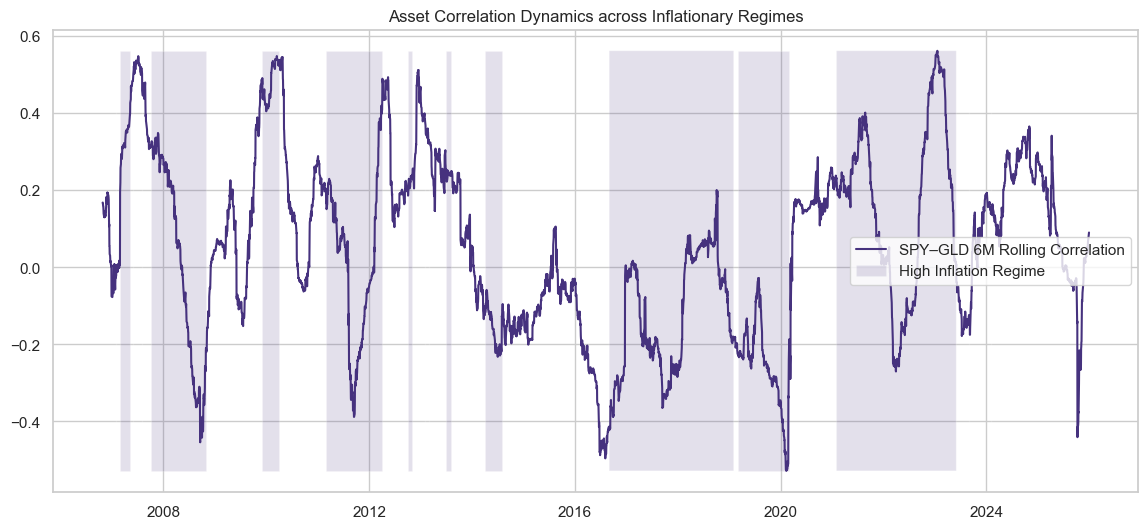

In [6]:
# Calculate returns
returns = np.log(prices_raw).diff().dropna()

# Rolling Correlation: Equities vs Commodities
rolling_corr = returns['SPY'].rolling(126).corr(returns['GLD']).dropna()

# Align macro regime exactly to rolling_corr index
macro_aligned = macro_states.reindex(rolling_corr.index)

# Boolean mask with same length
inflation_mask = (macro_aligned['is_high_inflation'] == 1).values

# Plot
plt.figure(figsize=(14, 6))

plt.plot(
    rolling_corr.index,
    rolling_corr.values,
    label='SPY–GLD 6M Rolling Correlation'
)

plt.fill_between(
    rolling_corr.index,
    rolling_corr.min(),
    rolling_corr.max(),
    where=inflation_mask,
    alpha=0.15,
    label='High Inflation Regime'
)

plt.title("Asset Correlation Dynamics across Inflationary Regimes")
plt.legend()
plt.show()

**Integrated Feature Export**

Finally, consolidating the explored engineered states and shocks into a single master feature file for subsequent Markov-Switching modeling.

In [7]:
final_features = pd.concat([macro_states, macro_shocks], axis=1).dropna()
output_path = "../data/processed/integrated_features.csv"
if not os.path.exists("../data/processed"):
    output_path = "data/processed/integrated_features.csv"

final_features.to_csv(output_path)
print(f"Success: {final_features.shape[0]} samples exported to {output_path}")
final_features.tail()

Success: 4966 samples exported to ../data/processed/integrated_features.csv


,growth_z,inflation_z,yield_curve,sentiment_z,is_high_growth,is_high_inflation,rate_shock,energy_shock,vol_shock
2025-12-23,0.327981,-1.033838,0.09,-1.396262,1.0,0.0,0.286888,0.430993,-0.047751
2025-12-24,0.326888,-1.034295,0.06,-1.394083,1.0,0.0,-0.855822,0.198941,-0.316159
2025-12-26,0.325795,-1.034752,0.05,-1.391910,1.0,0.0,-0.288282,-2.411488,0.077542
2025-12-29,0.324701,-1.035209,0.03,-1.389743,1.0,0.0,-0.576564,1.468557,0.357599
2025-12-30,0.323606,-1.035667,0.05,-1.387584,1.0,0.0,0.578584,0.000000,0.077474


#### **Exploring Features**

In [8]:
data_path = os.path.join(project_root, "data/processed")

data = {
        'prices': pd.read_csv(os.path.join(data_path, 'asset_prices.csv'), index_col=0, parse_dates=True),
        'returns': pd.read_csv(os.path.join(data_path, 'asset_returns.csv'), index_col=0, parse_dates=True),  
        'macro': pd.read_csv(os.path.join(data_path, 'macro_processed.csv'), index_col=0, parse_dates=True)
    }

feature_pipe = FeatureEngineer(data=data, lookback_windows=90)

In [9]:
all_feat = feature_pipe.generate_all_features(asset_pairs=[("SPY", "USO")])

2026-01-05 01:36:36,629 - INFO - ============================================================
2026-01-05 01:36:36,632 - INFO - Starting Feature Engineering Pipeline
2026-01-05 01:36:36,633 - INFO - ============================================================
2026-01-05 01:36:36,634 - INFO - Computing cointegration features: SPY vs USO
2026-01-05 01:36:37,060 - INFO -   Generated 5 cointegration features
2026-01-05 01:36:37,061 - INFO - Computing correlation regime features: SPY vs USO
2026-01-05 01:36:37,066 - INFO - Generated 4 correlation features
2026-01-05 01:36:37,066 - INFO - Computing volatility regime features: USO
2026-01-05 01:36:37,071 - INFO - Generated 3 volatility features
2026-01-05 01:36:37,072 - INFO - Computing momentum regime features: USO
2026-01-05 01:36:37,102 - INFO - Generated 4 momentum features
2026-01-05 01:36:37,102 - INFO - Computing volatility regime features: SPY
2026-01-05 01:36:37,104 - INFO - Generated 3 volatility features
2026-01-05 01:36:37,104 - IN

In [10]:
feat_summary = pd.DataFrame(all_feat.isnull().sum()/len(all_feat), columns=['Missing %']).sort_values(by='Missing %', ascending=False)

In [11]:
feat_summary

,Missing %
corr_median_SPY_USO_90d,1.000000
USO_vol_of_vol_90d,0.755274
SPY_vol_of_vol_90d,0.755274
ect_zscore_SPY_USO_90d,0.755274
corr_vol_SPY_USO_90d,0.755274
hedge_ratio_SPY_USO_90d,0.379747
momentum_SPY_90d,0.379747
SPY_vol_90,0.379747
momentum_USO_90d,0.379747
coint_pvalue_SPY_USO_90d,0.379747
